# ECE 4250 Final Kaggle Competition

In [1]:
import numpy as np
import nibabel as nib
import scipy
from scipy import ndimage, signal, stats
from scipy.optimize import fmin
from scipy.ndimage import rotate
import matplotlib.pyplot as plt
import math
import cmath
import cv2
from cv2 import warpAffine
from scipy.interpolate import RegularGridInterpolator
import tabulate
import random
import scipy
import skimage
from scipy import ndimage
from scipy import signal
from scipy import stats
from skimage.transform import warp, AffineTransform
from IPython.display import HTML, display
from skimage import transform, draw, filters
from collections import Counter

### Reading the data

In [2]:
training_img , training_sgm, validation_img , validation_sgm, testing_img = [], [], [], [], []

loc_validation_img, loc_validation_sgm = ['./4250-Data/Validation/IBSR_'+ i + '/images/analyze/IBSR_' + i +'_ana.img' for i in ['07', '15']],['./4250-Data/Validation/IBSR_'+ i + '/segmentation/analyze/IBSR_' + i +'_seg_ana.img' for i in ['07', '15']]

loc_training_img, loc_training_sgm  = ['./4250-Data/Training/IBSR_0'+ str(i) + '/images/analyze/IBSR_0' + str(i) +'_ana.img' for i in range(1,7)],['./4250-Data/Training/IBSR_0'+ str(i) + '/segmentation/analyze/IBSR_0' + str(i) +'_seg_ana.img' for i in range(1,7)]

loc_testing_img , temp = [], ['08','09','10','11','12','13','14','16','17']

for i in temp:
    loc_testing_img.append('./4250-Data/Testing/IBSR_'+ i + '/images/analyze/IBSR_' + i + '_ana.img')
    
def Sliced(img): ## input is of type nibabel image 
    img_data = img.get_fdata()
    return img_data[:, :, int(len(img_data[0,0])/2) ] ## removed the rotation

for i in range(len(loc_validation_img)):
    validation_img.append(Sliced(nib.load(loc_validation_img[i])))
    validation_sgm.append(Sliced(nib.load(loc_validation_sgm[i])))

for i in range(len(loc_training_img)):
    training_img.append(Sliced(nib.load(loc_training_img[i])))
    training_sgm.append(Sliced(nib.load(loc_training_sgm[i])))

for i in loc_testing_img:
    testing_img.append(Sliced(nib.load(i)))


In [3]:
## Using SkImage Affine Transfrm implementation for the geometric transformation

def Trnsfrm(moving_img, glbl_sc_x, glbl_sc_y, theta, t_x, t_y, sh, grid_size_out):
    
    dim1,dim2, dim3, dim4 = len(moving_img), len(moving_img[0]), grid_size_out[0], grid_size_out[1] 
    
    trns_y, trns_x = (np.array((dim3, dim4))-1) / 2.
    
    frnt, bck= transform.SimilarityTransform(translation=[-trns_x, -trns_y]), transform.SimilarityTransform(translation=[trns_x, trns_y])    
    
    Aff_Trnform = AffineTransform(scale=(glbl_sc_x, glbl_sc_y), rotation=np.deg2rad(theta), shear=sh, translation=(t_x, t_y))
    
    ret = warp( moving_img , ( frnt + (Aff_Trnform + bck )).inverse, order=1, clip=False, preserve_range=True, mode='symmetric')
    
    return ret


## Switched to Structural Similarity as opposed to MSE used in Milestone 2

def Loss(Trns_par, fix_img, mv_img):    
    
    geom = Trnsfrm(mv_img, *Trns_par, fix_img.shape) 

    return(-1* skimage.measure.compare_ssim(skimage.color.rgb2gray(geom), skimage.color.rgb2gray(fix_img)))
    

## Using Powell Optimizer for Minimizing

def Optmzer(fix_img, mv_img): ## Try different optimizations 
 
    norm_fix_img, norm_mv_img  = cv2.normalize(fix_img, 0, 255, cv2.NORM_MINMAX) , cv2.normalize(mv_img, 0, 255, cv2.NORM_MINMAX)   
    opt_par = scipy.optimize.minimize(Loss, (1,1,0,0,0,0), args = (norm_fix_img,norm_mv_img), method = 'Powell')
    transf_img = Trnsfrm(mv_img, *opt_par.x, fix_img.shape)
    
    return  transf_img, opt_par.x

In [4]:
opt_par, opt_par_val = [Optmzer(i, j)[1] for i in testing_img for j in training_img],[Optmzer(i, j)[1] for i in testing_img for j in validation_img]

sgm_img = np.zeros((9,8,256,256,1)) ## array for storing 6 training + 2 validation segments for
                                    ## each of the testing image

## Mapping each of the 6 training segments to each of the 8 testing images
for i in range(6): 
    sgm_img[0, i] = Trnsfrm(training_sgm[i], *opt_par[i], testing_img[0].shape)
    sgm_img[1, i] = Trnsfrm(training_sgm[i], *opt_par[6+i], testing_img[1].shape)
    sgm_img[2, i] = Trnsfrm(training_sgm[i], *opt_par[12+i], testing_img[2].shape)
    sgm_img[3, i] = Trnsfrm(training_sgm[i], *opt_par[18+i], testing_img[3].shape)
    sgm_img[4, i] = Trnsfrm(training_sgm[i], *opt_par[24+i], testing_img[4].shape)
    sgm_img[5, i] = Trnsfrm(training_sgm[i], *opt_par[30+i], testing_img[5].shape)
    sgm_img[6, i] = Trnsfrm(training_sgm[i], *opt_par[36+i], testing_img[6].shape)
    sgm_img[7, i] = Trnsfrm(training_sgm[i], *opt_par[42+i], testing_img[7].shape)
    sgm_img[8, i] = Trnsfrm(training_sgm[i], *opt_par[48+i], testing_img[8].shape)

## Mapping each of the 2 validation segments to each of the 8 testing images    
for i in range(2):
    sgm_img[0, i+6] = Trnsfrm(validation_sgm[i], *opt_par_val[i]   , testing_img[0].shape)
    sgm_img[1, i+6] = Trnsfrm(validation_sgm[i], *opt_par_val[i+2] , testing_img[1].shape)
    sgm_img[2, i+6] =Trnsfrm(validation_sgm[i], *opt_par_val[i+4] , testing_img[2].shape)
    sgm_img[3, i+6] =Trnsfrm(validation_sgm[i], *opt_par_val[i+6] , testing_img[3].shape)
    sgm_img[4, i+6] =Trnsfrm(validation_sgm[i], *opt_par_val[i+8] , testing_img[4].shape)
    sgm_img[5, i+6] =Trnsfrm(validation_sgm[i], *opt_par_val[i+10], testing_img[5].shape)
    sgm_img[6, i+6] =Trnsfrm(validation_sgm[i], *opt_par_val[i+12], testing_img[6].shape)
    sgm_img[7, i+6] =Trnsfrm(validation_sgm[i], *opt_par_val[i+14], testing_img[7].shape)
    sgm_img[8, i+6] =Trnsfrm(validation_sgm[i], *opt_par_val[i+16], testing_img[8].shape)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:24: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.


In [5]:
final_set = np.zeros((9,256,256,8))
for i in range(9):
    for j in range(8):
        final_set[i,:,:,j] = sgm_img[i,j,:,:,0]


## Computing the most frequent training label        
def Most_Freq_Label(img):
    
    ret = np.zeros((256,256))
    
    ## iterating over all the pixel values
    for px in range(0 , len(img)):
        for py in range(0 , len(img[0])):
            
            final_lbl = []
            for i in range(len(img[0][0])):
                final_lbl.append(img[px][py][i])
                
            ## storing indices of the non-zero values     
            non_zero_val = np.nonzero(final_lbl)
            
            ##Finding the mode and in case of a tie picking the one which has a higher value
            
            final_lbl.sort()
            cnt = Counter(final_lbl)
            cnt_var = cnt.most_common()
            cnt_var.sort(key = lambda x: x[1])
            
            mode_val = cnt_var[len(cnt_var) -1][0]
            
            
            ## Ignoring mode of 0 if non zero values present in the data
            if(len(non_zero_val[0]) > 0 and  mode_val == 0):
                
                temp_lbl = []
                for i in range(0 , len(non_zero_val[0])):
                    temp_lbl.append(final_lbl[non_zero_val[0][i]])
                 
                ## Finding the mode of non-zero pixel values and in case of a 
                ## tie picking the one which has a higher value
                
                temp_lbl.sort()
                cnt1 = Counter(temp_lbl)
                cnt1_var = cnt1.most_common()
                cnt1_var.sort(key = lambda x: x[1])
                
                ret[px][py] = cnt1_var[len(cnt1_var) -1][0]
            
            ## Mapping the max of the pixel value in case obtain the same mode
            else:
                ret[px][py] = mode_val
    
    return ret        



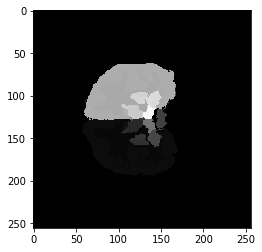

In [6]:
Final_Most_Freq = np.zeros((9,256,256))

for i in range(9):
    Final_Most_Freq[i] = Most_Freq_Label(final_set[i])

##test  
plt.imshow(Final_Most_Freq[0], cmap = 'gray')


In [7]:
## Final Block for generating csv file

b_msk_2,b_msk_3,b_msk_41,b_msk_42 = [],[],[],[]

def Mask_bin(img, ROI):
    imgb = np.array(img)
    return (imgb == ROI)


for i in range(9):
    b_msk_2.append(Mask_bin(Final_Most_Freq[i], 2))
    b_msk_42.append(Mask_bin(Final_Most_Freq[i], 42))
    b_msk_3.append(Mask_bin(Final_Most_Freq[i], 3))
    b_msk_41.append(Mask_bin(Final_Most_Freq[i], 41))
    

    
## Submission to Kaggle code    

brain_reg = ['-left-wm', '-left-cortex', '-right-wm', '-right-cortex']
test_lbl = ['8','9','10','11','12','13','14','16','17']
final_lbl = [] ##For storing the data in this format

for i in test_lbl:
    for j in brain_reg:
        final_lbl.append(i+j)



def rle_encode(img):
    '''
    img: numpy array, 1 - mask, 0 - background
    Returns run length as string formated
    '''
    pixels = img.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)


data = []
for i in range(len(test_lbl)):
    data.append(rle_encode(b_msk_2[i]))
    data.append(rle_encode(b_msk_3[i]))
    data.append(rle_encode(b_msk_41[i]))
    data.append(rle_encode(b_msk_42[i]))


import pandas as pd
### ids: list containing the 36 IDs as described above  ###
### data: list containing the 36 binary segmentation masks in RLE format ###
    
df = pd.DataFrame({"Id": final_lbl, "Predicted": data})
df.to_csv('submission.csv', index = False)


___